# Libraries and paths

In [ ]:
import os
import cv2
import seaborn as sns
import numpy as np
import random
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import shutil
from sklearn import datasets, preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support
from random import choice
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
test_path = "/content/drive/MyDrive/CSE428/Project/Group_5/test"

In [ ]:
train_path = "/content/drive/MyDrive/CSE428/Project/Group_5/train"
augment_path = "/content/drive/MyDrive/CSE428/Project/Group_5/aug_train"

# Augmentation

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_class_distribution(path):
    class_names = os.listdir(path)
    class_counts = {}
    for class_name in class_names:
        class_folder_path = os.path.join(path, class_name)
        if os.path.isdir(class_folder_path):  # Check if it's a folder
            class_counts[class_name] = len(os.listdir(class_folder_path))
    return class_counts

# Get class distribution for test and train sets
test_class_distribution = get_class_distribution(test_path)
train_class_distribution = get_class_distribution(train_path)

In [ ]:
print("Training Set Class Distribution:")
for class_name, count in train_class_distribution.items():
    print(f"{class_name}: {count} instances")

print("\nTest Set Class Distribution:")
for class_name, count in test_class_distribution.items():
    print(f"{class_name}: {count} instances")


Training Set Class Distribution:
fence: 500 instances
projectile: 500 instances
reel: 250 instances
pill-bottle: 500 instances
snail: 400 instances

Test Set Class Distribution:
projectile: 50 instances
fence: 50 instances
pill-bottle: 50 instances
reel: 50 instances
snail: 50 instances


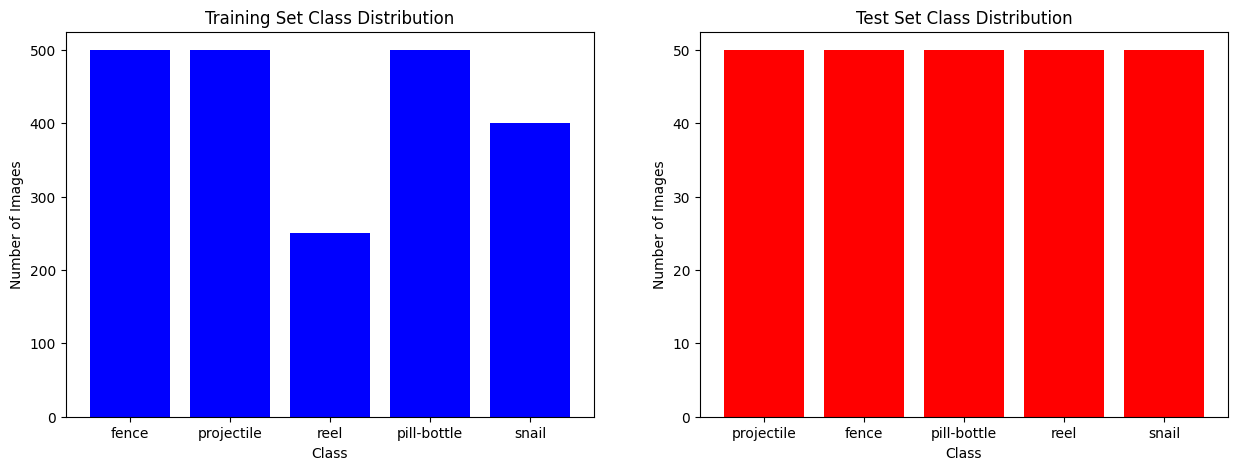

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot for train set
ax[0].bar(train_class_distribution.keys(), train_class_distribution.values(), color='b')
ax[0].set_title("Training Set Class Distribution")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Number of Images")

# Plot for test set
ax[1].bar(test_class_distribution.keys(), test_class_distribution.values(), color='r')
ax[1].set_title("Test Set Class Distribution")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Number of Images")

plt.show()

In [ ]:
# Check if augment_path exists, if not create it
if not os.path.exists(augment_path):
    os.mkdir(augment_path)

# Iterate over each class folder in train_path
for class_name in tqdm(os.listdir(train_path), desc="Copying classes"):
    src_folder = os.path.join(train_path, class_name)
    dest_folder = os.path.join(augment_path, class_name)

    # Create the class folder in augment_path if it doesn't exist
    if not os.path.exists(dest_folder):
        os.mkdir(dest_folder)

    # Copy each image from the class folder in train_path to the class folder in augment_path
    for filename in tqdm(os.listdir(src_folder), desc=f"Copying images for {class_name}", leave=False):
        src = os.path.join(src_folder, filename)
        dest = os.path.join(dest_folder, filename)
        shutil.copy2(src, dest)


Copying classes:   0%|          | 0/5 [00:00<?, ?it/s]

Copying images for fence:   0%|          | 0/500 [00:00<?, ?it/s]

Copying images for projectile:   0%|          | 0/500 [00:00<?, ?it/s]

Copying images for reel:   0%|          | 0/250 [00:00<?, ?it/s]

Copying images for pill-bottle:   0%|          | 0/500 [00:00<?, ?it/s]

Copying images for snail:   0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
augment_class_distribution = get_class_distribution(augment_path)

print("Training Set Class Distribution:")
for class_name, count in augment_class_distribution.items():
    print(f"{class_name}: {count} instances")

Training Set Class Distribution:
fence: 500 instances
projectile: 500 instances
reel: 500 instances
pill-bottle: 500 instances
snail: 500 instances


In [ ]:
# Data Augmentation Configuration
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Perform data augmentation and save augmented images for 'reel' and 'snail' classes
for class_name in tqdm([c for c in os.listdir(train_path) if c in ['reel', 'snail']], desc="Classes"):
    class_folder = os.path.join(train_path, class_name)
    augment_class_folder = os.path.join(augment_path, class_name)

    # Keep augmenting until the number of images in the folder reaches 500
    while len(os.listdir(augment_class_folder)) < 500:
        for filename in tqdm(os.listdir(class_folder), desc=f"Augmenting {class_name}", leave=False):

            img_path = os.path.join(class_folder, filename)
            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for batch in datagen.flow(x, batch_size=1, save_to_dir=augment_class_folder, save_prefix=f"aug_{class_name}", save_format='jpeg'):
                if len(os.listdir(augment_class_folder)) >= 500:
                    break
            if len(os.listdir(augment_class_folder)) >= 500:
                break

Classes:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Load and show the new class distribution
augmented_train_class_distribution = get_class_distribution(augment_path)
print("Augmented Training Set Class Distribution:")
for class_name, count in augmented_train_class_distribution.items():
    print(f"{class_name}: {count} instances")

Augmented Training Set Class Distribution:
fence: 500 instances
projectile: 500 instances
reel: 500 instances
pill-bottle: 500 instances
snail: 500 instances


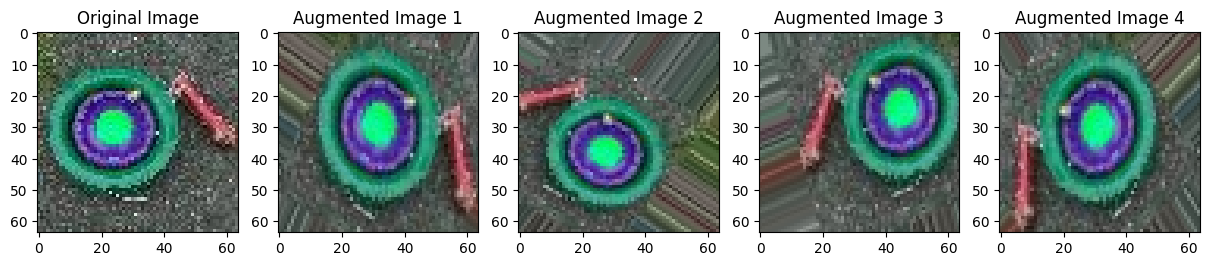

In [ ]:
# Choose a random class and a random image within that class
random_class = "reel"
random_class_folder = os.path.join(train_path, random_class)
random_img_name = choice(os.listdir(random_class_folder))
random_img_path = os.path.join(random_class_folder, random_img_name)

# Load and preprocess the random image
img = load_img(random_img_path)
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# Initialize a list to collect augmented images
augmented_images = []

# Generate augmented images
i = 0
for batch in datagen.flow(x, batch_size=1):
    augmented_images.append(array_to_img(batch[0]))
    i += 1
    if i >= 4:  # for demonstration, let's generate 4 augmented images
        break

# Plot the original image along with the augmented images
plt.figure(figsize=(15, 10))

# Plot original image
plt.subplot(1, 5, 1)
plt.imshow(img)
plt.title('Original Image')

# Plot augmented images
for idx, aug_img in enumerate(augmented_images, start=2):
    plt.subplot(1, 5, idx)
    plt.imshow(aug_img)
    plt.title(f'Augmented Image {idx-1}')

plt.show()

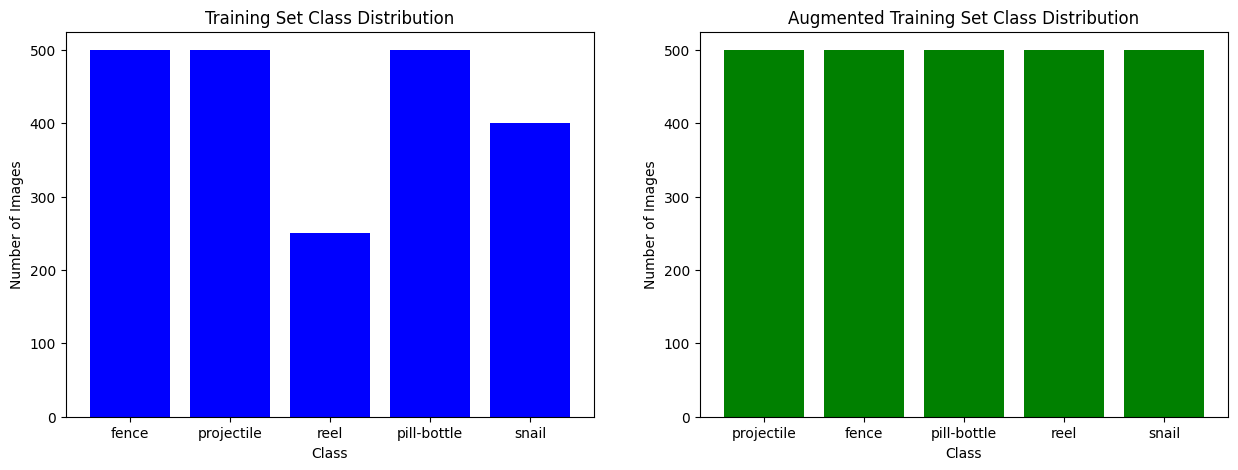

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot for train set
ax[0].bar(train_class_distribution.keys(), train_class_distribution.values(), color='b')
ax[0].set_title("Training Set Class Distribution")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Number of Images")

# Plot for test set
ax[1].bar(test_class_distribution.keys(), augmented_train_class_distribution.values(), color='g')
ax[1].set_title("Augmented Training Set Class Distribution")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Number of Images")

plt.show()

# Functions

In [ ]:
class_names = []
def load_data(main_folder_path):
    X = [] #store the image data
    y = [] #store the class labels
    class_folders = sorted(os.listdir(main_folder_path))

    for class_idx, class_folder in tqdm(enumerate(class_folders), total=len(class_folders), desc="Loading Classes"):
        class_folder_path = os.path.join(main_folder_path, class_folder)
        if class_folder not in class_names:
          class_names.append(class_folder)

        images = os.listdir(class_folder_path)
        for image_name in images:
            image_path = os.path.join(class_folder_path, image_name)
            image = load_img(image_path, target_size=(64, 64))
            image = img_to_array(image) / 255.0 # Normalize to [0,1]
            X.append(image)
            y.append(class_idx)

    return np.array(X), np.array(y)

In [ ]:
def sharpen_image(image):
    sharpening_kernel = np.array([[-1,-1,-1],
                                  [-1, 9,-1],
                                  [-1,-1,-1]])
    sharpened = cv2.filter2D(image, -1, sharpening_kernel)
    sharpened_clipped = np.clip(sharpened, 0, 1) # Clip values to the range [0, 1]
    return sharpened_clipped

In [ ]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10,7))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Data Loading and Split

In [ ]:
for label, class_name in enumerate(class_names):
    print(f"Class Name: {class_name} - Label: {label}")

In [ ]:
X_train, y_train = load_data(augment_path)
X_test, y_test = load_data(test_path)

Loading Classes:   0%|          | 0/5 [00:00<?, ?it/s]

Loading Classes:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2510, 64, 64, 3) (2510,)
(250, 64, 64, 3) (250,)


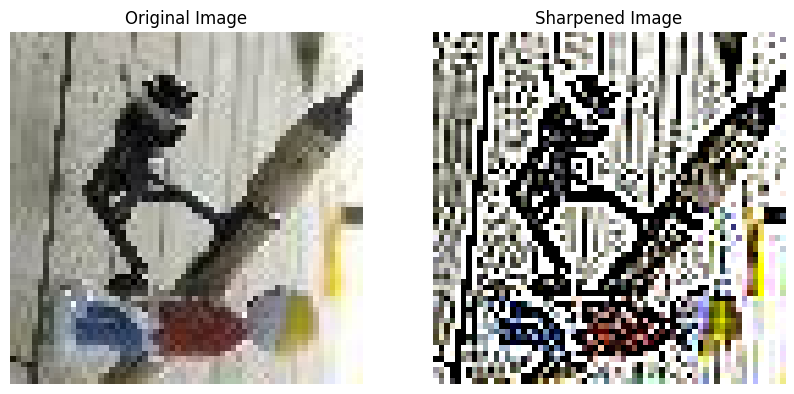

In [ ]:
image_idx = 1539

original_image = X_train[image_idx]
sharpened_image = sharpen_image(original_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sharpened_image)
plt.title('Sharpened Image')
plt.axis('off')

plt.show()

In [ ]:
X_train = np.array([sharpen_image(img) for img in X_train])
X_test = np.array([sharpen_image(img) for img in X_test])

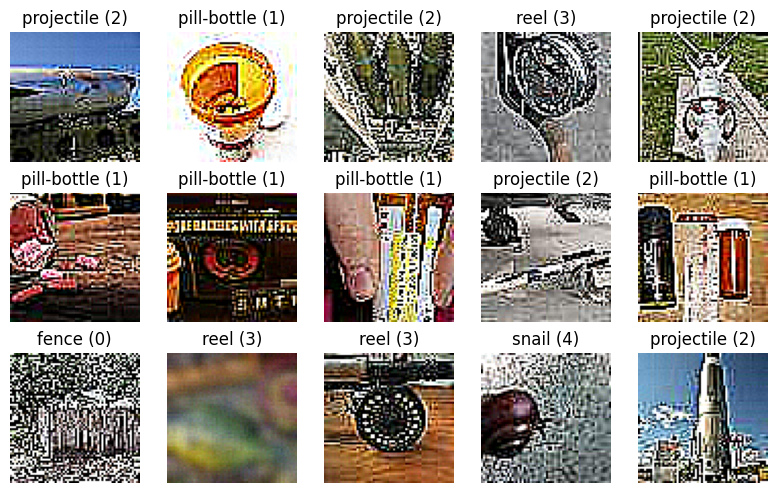

In [ ]:
random_indices = random.sample(range(X_train.shape[0]), 15)

fig, axes = plt.subplots(3, 5, figsize=(8, 5))
for idx, ax in zip(random_indices, axes.flatten()):
    image = X_train[idx].reshape(64, 64, 3)
    label = y_train[idx]
    class_name = class_names[label]
    ax.imshow(image)
    ax.set_title(f"{class_name} ({label})")
    ax.axis('off')

plt.tight_layout()
plt.show()

# ResNet-34

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride)(x)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, kernel_size, padding='same', strides=stride)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)

    return x

def build_simplified_resnet34(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=1, padding='same')(x)

    for _ in range(3):
        x = residual_block(x, 64)
    x = layers.Dropout(0.3)(x)

    for _ in range(4):
        x = residual_block(x, 64, stride=2 if _ == 0 else 1)
    x = layers.Dropout(0.3)(x)

    for _ in range(6):
        x = residual_block(x, 128, stride=2 if _ == 0 else 1)
    x = layers.Dropout(0.3)(x)

    for _ in range(3):
        x = residual_block(x, 256, stride=2 if _ == 0 else 1)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(5, activation='softmax')(x)

    return models.Model(inputs, outputs)

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=5)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_simplified_resnet34_model.h5', monitor='val_loss', save_best_only=True)

# Compile and train the model
input_shape = (64, 64, 3)
simplified_resnet34_model = build_simplified_resnet34(input_shape)
simplified_resnet34_model.compile(optimizer=RMSprop(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = simplified_resnet34_model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32,
                                         validation_split=0.1, callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
71/71 [==============================] - 42s 209ms/step - loss: 1.4670 - accuracy: 0.3355 - val_loss: 2.7233 - val_accuracy: 0.0000e+00
Epoch 2/50
71/71 [==============================] - 12s 175ms/step - loss: 1.3571 - accuracy: 0.4086 - val_loss: 5.8606 - val_accuracy: 0.0000e+00
Epoch 3/50
71/71 [==============================] - 12s 174ms/step - loss: 1.2724 - accuracy: 0.4745 - val_loss: 8.0907 - val_accuracy: 0.0000e+00
Epoch 4/50
71/71 [==============================] - 12s 173ms/step - loss: 1.2403 - accuracy: 0.4865 - val_loss: 13.2200 - val_accuracy: 0.0000e+00
Epoch 5/50
71/71 [==============================] - 12s 173ms/step - loss: 1.1618 - accuracy: 0.5334 - val_loss: 4.2545 - val_accuracy: 0.0000e+00
Epoch 6/50
71/71 [==============================] - 12s 173ms/step - loss: 1.1141 - accuracy: 0.5529 - val_loss: 3.5898 - val_accuracy: 0.2709
Epoch 7/50
71/71 [==============================] - 13s 183ms/step - loss: 1.1060 - accuracy: 0.5529 - val_loss: 1.8964 -

In [ ]:
simplified_resnet34_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_49 (Conv2D)             (None, 64, 64, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_49 (BatchN  (None, 64, 64, 64)  256         ['conv2d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_33 (ReLU)                (None, 64, 64, 64)   0           ['batch_normalization_49[0]

- An initial convolutional layer: 1 layer
- First set of residual blocks: 3 blocks \(\times\) 2 layers = 6 layers
- Second set of residual blocks: 4 blocks \(\times\) 2 layers = 8 layers
- Third set of residual blocks: 6 blocks \(\times\) 2 layers = 12 layers
- Fourth set of residual blocks: 3 blocks \(\times\) 2 layers = 6 layers
- A final fully connected layer (dense layer for classification): 1 layer

So, the total number of layers with learnable parameters would be:

1(Initial Conv)+6(First set)+8(Second set)+12(Third set)+6(Fourth set)+1(Final FC layer)=34 layers

In [ ]:
y_test_norm = to_categorical(y_test, num_classes=5)
# Evaluate the model on the test set
test_loss, test_accuracy = simplified_resnet34_model.evaluate(X_test, y_test_norm)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 [==============================] - 1s 98ms/step - loss: 1.2872 - accuracy: 0.6120
Test Loss: 1.2872172594070435
Test Accuracy: 0.6119999885559082


8/8 [==============================] - 1s 42ms/step
Accuracy: 0.612
Sensitivity (per class): [0.8, 0.56, 0.6, 0.26, 0.84]
Specificity (per class): [0.96, 0.97, 0.875, 0.92, 0.79]
Positive Predictive Value (PPV) (per class): [0.8333333333333334, 0.8235294117647058, 0.5454545454545454, 0.4482758620689655, 0.5]
Negative Predictive Value (NPV) (per class): [0.9504950495049505, 0.8981481481481481, 0.8974358974358975, 0.832579185520362, 0.9518072289156626]
F1 Score: 0.6020802728799813


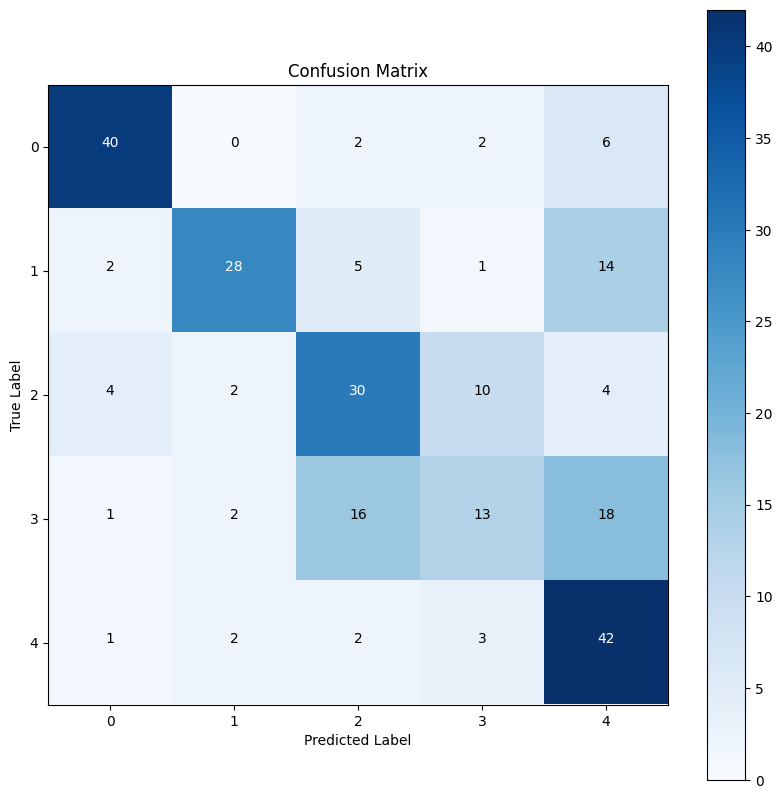

In [ ]:
def evaluate_model(model, X, y):
    y_pred = np.argmax(model.predict(X), axis=-1)
    accuracy = accuracy_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')

    sensitivity, specificity, PPV, NPV = [], [], [], []
    for i in range(len(conf_matrix)):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FN + FP)

        sensitivity.append(TP / (TP + FN) if (TP + FN) != 0 else 0)
        specificity.append(TN / (TN + FP) if (TN + FP) != 0 else 0)
        PPV.append(TP / (TP + FP) if (TP + FP) != 0 else 0)
        NPV.append(TN / (TN + FN) if (TN + FN) != 0 else 0)

    print("Accuracy:", accuracy)
    print("Sensitivity (per class):", sensitivity)
    print("Specificity (per class):", specificity)
    print("Positive Predictive Value (PPV) (per class):", PPV)
    print("Negative Predictive Value (NPV) (per class):", NPV)
    print("F1 Score:", f1)

    plot_confusion_matrix(conf_matrix)

def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = range(len(cm))
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Annotate each cell with the numeric value
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, str(cm[i][j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.show()

# Assuming your test data and labels are stored in x_test and y_test
# Note: Make sure to convert y_test to integer labels if it's one-hot encoded
evaluate_model(simplified_resnet34_model, X_test, np.argmax(y_test_norm, axis=1))


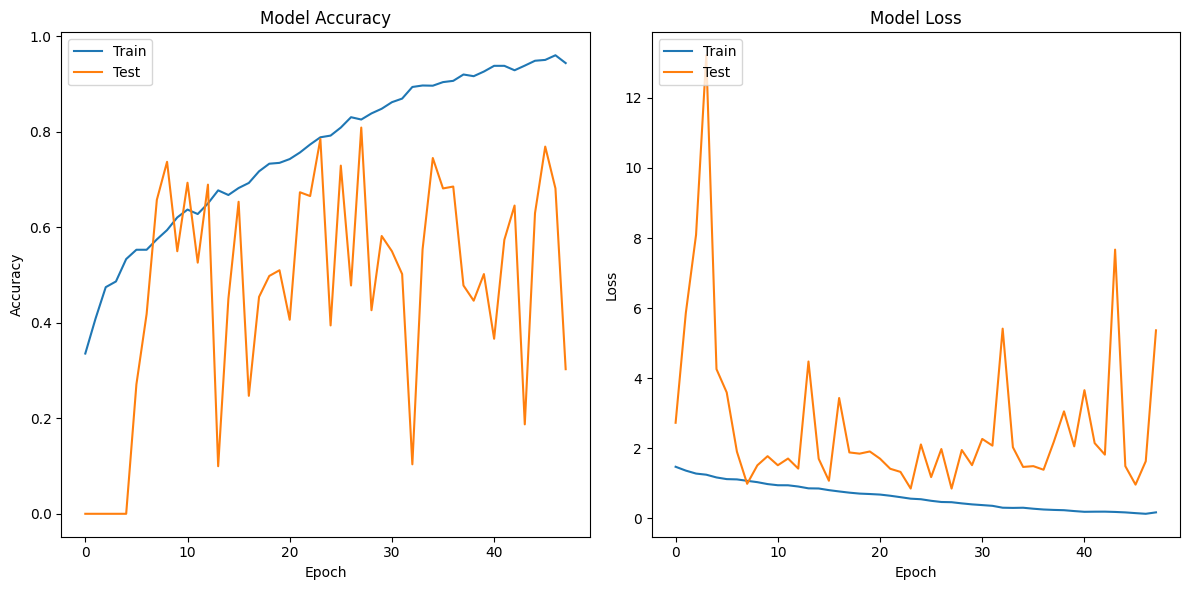

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


Shape of X_test: (250, 64, 64, 3)
Shape of y_test_norm: (250, 5)
8/8 [==============================] - 0s 40ms/step
Shape of y_pred: (250,)
Shape of y_true: (250,)
Misclassified indices: [  0  12  14  16  28  29  31  35  42  49  52  53  54  57  60  63  66  70
  75  79  81  83  84  85  86  87  88  89  95  96  97  99 100 102 103 104
 105 113 115 117 120 123 125 128 129 131 134 138 140 144 146 148 150 151
 152 153 154 155 156 157 158 159 162 164 165 167 168 169 170 172 173 174
 175 176 177 178 182 183 186 187 188 189 190 191 192 193 195 198 199 205
 213 217 218 220 231 232 247]


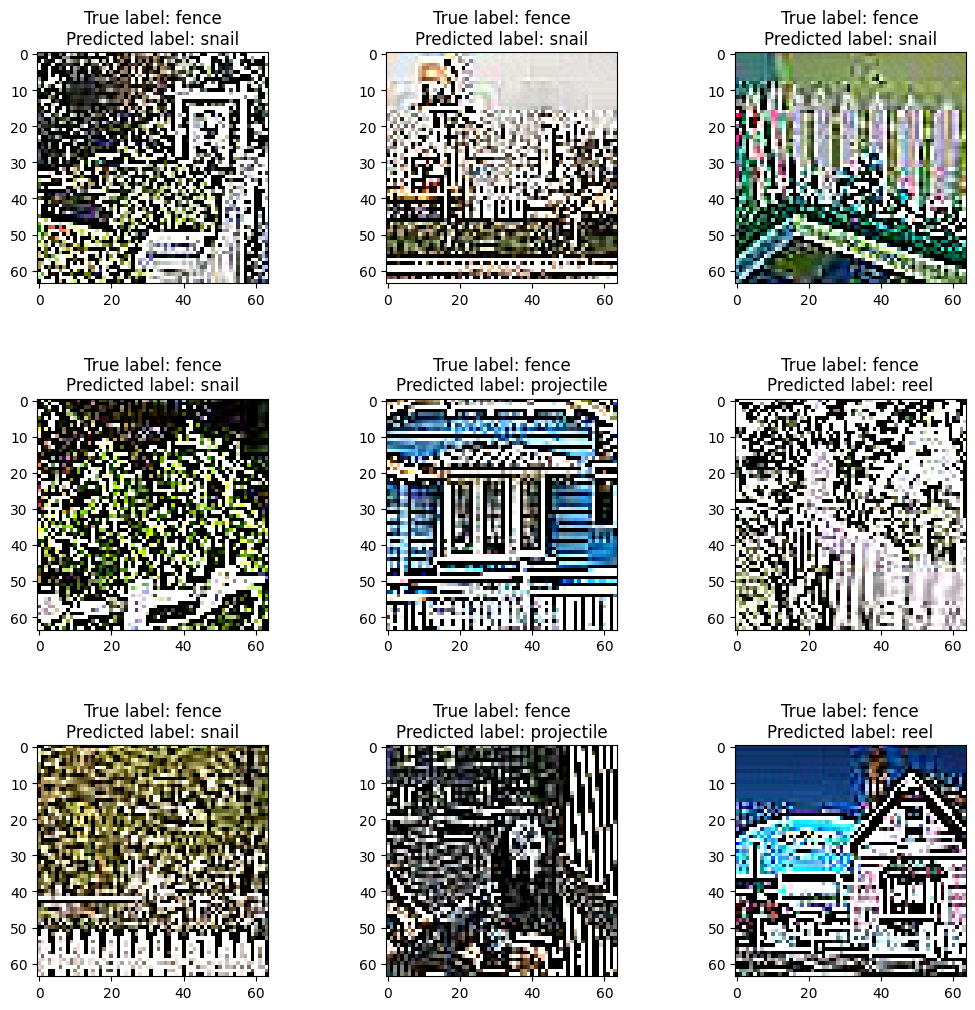

In [ ]:
import matplotlib.pyplot as plt

# Define a list of label names based on your actual labels
label_names = ['fence', 'pill-bottle', 'projectile', 'reel', 'snail']

print("Shape of X_test:", X_test.shape)
print("Shape of y_test_norm:", y_test_norm.shape)

# Get predicted labels
y_pred = np.argmax(simplified_resnet34_model.predict(X_test), axis=-1)

# Get true labels
y_true = np.argmax(y_test_norm, axis=-1)

print("Shape of y_pred:", y_pred.shape)
print("Shape of y_true:", y_true.shape)

# Find misclassified examples
misclassified_idx = np.where(y_pred != y_true)[0]
print("Misclassified indices:", misclassified_idx)

# Show some misclassified examples
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Increase the spaces between plots

for i, idx in enumerate(misclassified_idx[:9]):
    ax = axes[i // 3, i % 3]
    ax.imshow((X_test[idx] * 255).astype('uint8'))  # Remove cmap='gray' if your images are in color
    ax.set_title(f"True label: {label_names[y_true[idx]]}\nPredicted label: {label_names[y_pred[idx]]}")

plt.show()


# Inception Model

In [ ]:
def inception_module(x, filters):
    # 1x1 conv
    conv1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)

    # 3x3 conv
    conv3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)

    # 5x5 conv
    conv5 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(x)

    # 3x3 max pooling
    pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)

    # concatenate filters, assumes filters/channels last
    x = layers.Concatenate(axis=-1)([conv1, conv3, conv5, pool])

    return x

def build_simple_inception(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 16)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 32)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(5, activation='softmax')(x)

    return models.Model(inputs, outputs)

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=5)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_simple_inception_model.h5', monitor='val_loss', save_best_only=True)

# Compile and train the model
input_shape = (64, 64, 3)
simple_inception_model = build_simple_inception(input_shape)
simple_inception_model.compile(optimizer=RMSprop(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = simple_inception_model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32,
                                     validation_split=0.1, callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
71/71 [==============================] - 7s 25ms/step - loss: 1.5770 - accuracy: 0.2625 - val_loss: 2.0834 - val_accuracy: 0.0000e+00
Epoch 2/50
71/71 [==============================] - 1s 8ms/step - loss: 1.5300 - accuracy: 0.3581 - val_loss: 2.1042 - val_accuracy: 0.0000e+00
Epoch 3/50
71/71 [==============================] - 1s 8ms/step - loss: 1.4888 - accuracy: 0.3807 - val_loss: 2.1390 - val_accuracy: 0.0000e+00
Epoch 4/50
71/71 [==============================] - 1s 8ms/step - loss: 1.4422 - accuracy: 0.4011 - val_loss: 2.0595 - val_accuracy: 0.0000e+00
Epoch 5/50
71/71 [==============================] - 1s 9ms/step - loss: 1.4025 - accuracy: 0.4205 - val_loss: 2.0221 - val_accuracy: 0.0000e+00
Epoch 6/50
71/71 [==============================] - 1s 8ms/step - loss: 1.3672 - accuracy: 0.4440 - val_loss: 1.8631 - val_accuracy: 0.0000e+00
Epoch 7/50
71/71 [==============================] - 1s 7ms/step - loss: 1.3336 - accuracy: 0.4533 - val_loss: 2.0929 - val_accuracy: 0.

In [ ]:
# Model Summary for the Inception model
simple_inception_model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_105 (Conv2D)            (None, 64, 64, 16)   448         ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 32, 32, 16)  0           ['conv2d_105[0][0]']             
                                                                                                  
 conv2d_106 (Conv2D)            (None, 32, 32, 16)   272         ['max_pooling2d_7[0][0]']        
                                                                                            

In [ ]:
y_test_norm = to_categorical(y_test, num_classes=5)
# Evaluate the model on the test set
test_loss, test_accuracy = simple_inception_model.evaluate(X_test, y_test_norm)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 [==============================] - 0s 7ms/step - loss: 1.1494 - accuracy: 0.5160
Test Loss: 1.1494423151016235
Test Accuracy: 0.515999972820282


8/8 [==============================] - 1s 63ms/step
Accuracy: 0.516
Sensitivity (per class): [0.72, 0.76, 0.54, 0.18, 0.38]
Specificity (per class): [0.94, 0.86, 0.79, 0.875, 0.93]
Positive Predictive Value (PPV) (per class): [0.75, 0.5757575757575758, 0.391304347826087, 0.2647058823529412, 0.5757575757575758]
Negative Predictive Value (NPV) (per class): [0.9306930693069307, 0.9347826086956522, 0.8729281767955801, 0.8101851851851852, 0.8571428571428571]
F1 Score: 0.503152968707217


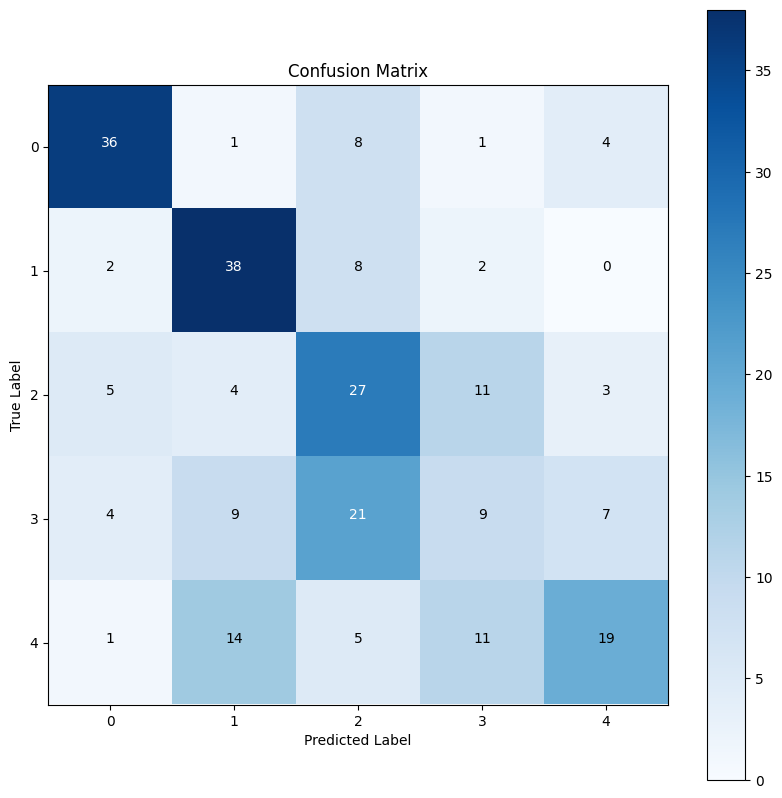

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def evaluate_model(model, X, y):
    y_pred = np.argmax(model.predict(X), axis=-1)
    y_true = np.argmax(y, axis=-1)  # Assuming y is one-hot encoded
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    sensitivity, specificity, PPV, NPV = [], [], [], []
    for i in range(len(conf_matrix)):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FN + FP)

        sensitivity.append(TP / (TP + FN) if (TP + FN) != 0 else 0)
        specificity.append(TN / (TN + FP) if (TN + FP) != 0 else 0)
        PPV.append(TP / (TP + FP) if (TP + FP) != 0 else 0)
        NPV.append(TN / (TN + FN) if (TN + FN) != 0 else 0)

    print("Accuracy:", accuracy)
    print("Sensitivity (per class):", sensitivity)
    print("Specificity (per class):", specificity)
    print("Positive Predictive Value (PPV) (per class):", PPV)
    print("Negative Predictive Value (NPV) (per class):", NPV)
    print("F1 Score:", f1)

    plot_confusion_matrix(conf_matrix)

# Assuming your test data and labels are stored in X_test and y_test_norm
evaluate_model(simple_inception_model, X_test, y_test_norm)


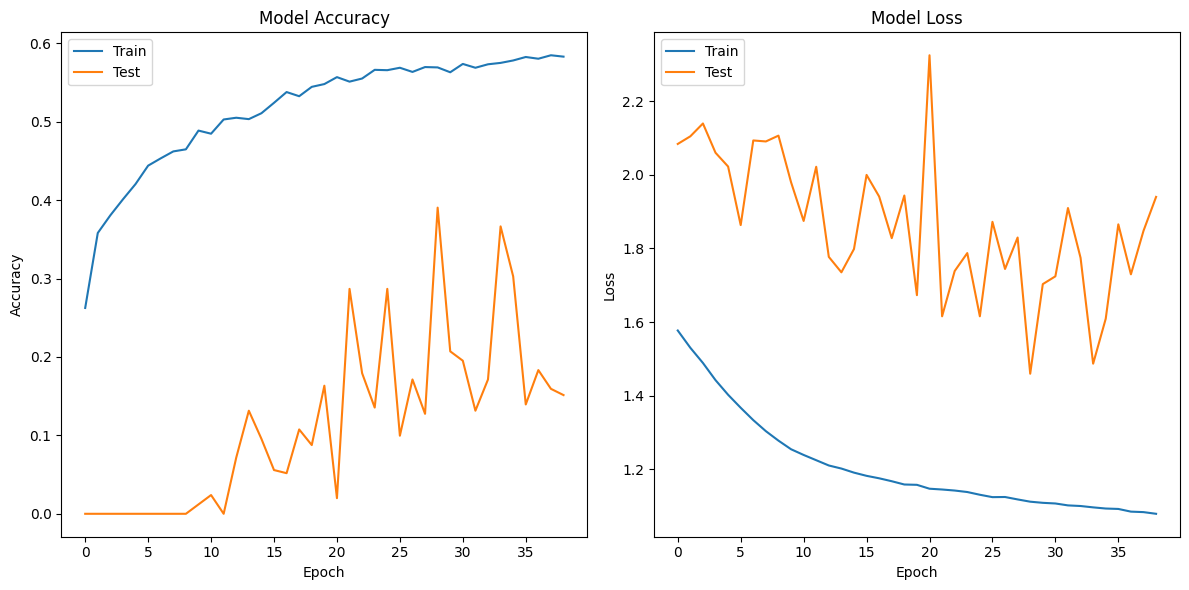

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


Shape of X_test: (250, 64, 64, 3)
Shape of y_test_norm: (250, 5)
8/8 [==============================] - 0s 4ms/step
Shape of y_pred: (250,)
Shape of y_true: (250,)
Misclassified indices: [  6   9  12  13  14  16  18  22  31  32  42  47  48  49  54  60  62  65
  70  75  79  86  89  91  96  99 102 103 108 111 112 115 117 120 123 124
 125 129 133 134 135 137 139 140 141 142 144 145 148 150 151 154 155 156
 157 158 161 162 163 164 165 166 167 168 169 170 171 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 191 192 193 197 198 199
 202 203 204 205 206 207 208 212 215 216 217 218 219 220 222 223 225 229
 230 231 232 235 236 237 238 239 241 242 245 246 247]


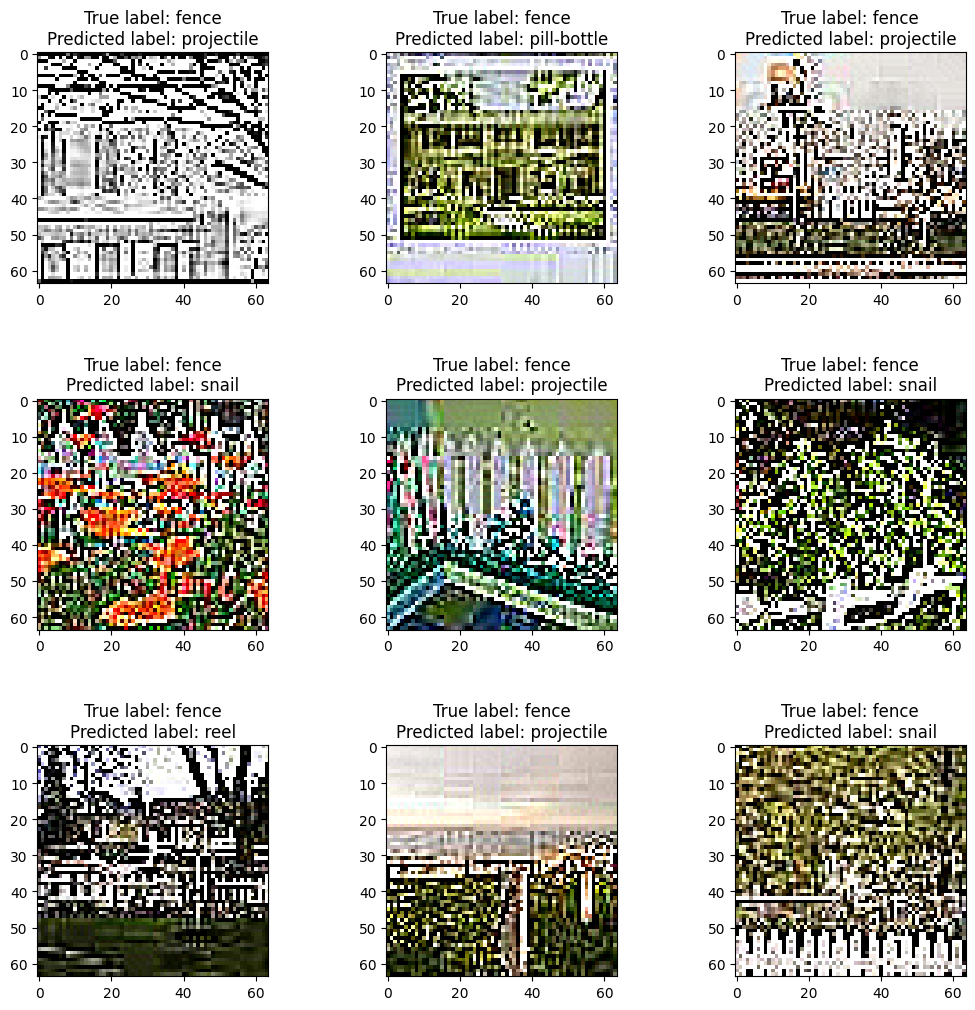

In [ ]:


# Define a list of label names based on your actual labels
label_names = ['fence', 'pill-bottle', 'projectile', 'reel', 'snail']

print("Shape of X_test:", X_test.shape)
print("Shape of y_test_norm:", y_test_norm.shape)

# Get predicted labels
y_pred = np.argmax(simple_inception_model.predict(X_test), axis=-1)

# Get true labels
y_true = np.argmax(y_test_norm, axis=-1)

print("Shape of y_pred:", y_pred.shape)
print("Shape of y_true:", y_true.shape)

# Find misclassified examples
misclassified_idx = np.where(y_pred != y_true)[0]
print("Misclassified indices:", misclassified_idx)

# Show some misclassified examples
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Increase the spaces between plots

for i, idx in enumerate(misclassified_idx[:9]):
    ax = axes[i // 3, i % 3]
    ax.imshow((X_test[idx] * 255).astype('uint8'))  # Remove cmap='gray' if your images are in color
    ax.set_title(f"True label: {label_names[y_true[idx]]}\nPredicted label: {label_names[y_pred[idx]]}")

plt.show()


# Custom Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Define a function for a simplified residual block
def simple_res_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)

    # Adding the shortcut to the output
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

# Input layer
input = Input(shape=(64, 64, 3))

# Initial Conv Layer
x = Conv2D(64, (3, 3), padding="same", strides=1)(input)
x = BatchNormalization()(x)
x = ReLU()(x)

# Residual Blocks
x = simple_res_block(x, 64)
x = simple_res_block(x, 64)
x = simple_res_block(x, 64)

# Global Average Pooling Layer
x = GlobalAveragePooling2D()(x)

# Fully Connected Layer (Dense Layer)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)

# Output Layer
output = Dense(5, activation="softmax")(x)

# Creating the Model
simple_resnet_model = Model(inputs=input, outputs=output)

# Show model summary
simple_resnet_model.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_358 (Conv2D)            (None, 64, 64, 64)   1792        ['input_29[0][0]']               
                                                                                                  
 batch_normalization_246 (Batch  (None, 64, 64, 64)  256         ['conv2d_358[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_181 (ReLU)               (None, 64, 64, 64)   0           ['batch_normalization_246[

In [ ]:
# Compile the model
simple_resnet_model.compile(optimizer=RMSprop(1e-4),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=5)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_simple_resnet_model.h5',
                                   monitor='val_loss',
                                   save_best_only=True)

# Train the model
history = simple_resnet_model.fit(X_train, y_train_one_hot,
                                  epochs=50,
                                  batch_size=32,
                                  validation_split=0.1,
                                  callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
71/71 [==============================] - 10s 76ms/step - loss: 1.7528 - accuracy: 0.3417 - val_loss: 1.9749 - val_accuracy: 0.0000e+00
Epoch 2/50
71/71 [==============================] - 5s 64ms/step - loss: 1.3993 - accuracy: 0.4351 - val_loss: 2.3802 - val_accuracy: 0.0000e+00
Epoch 3/50
71/71 [==============================] - 4s 63ms/step - loss: 1.3054 - accuracy: 0.4728 - val_loss: 2.6916 - val_accuracy: 0.0000e+00
Epoch 4/50
71/71 [==============================] - 5s 66ms/step - loss: 1.2390 - accuracy: 0.5175 - val_loss: 2.5734 - val_accuracy: 0.0040
Epoch 5/50
71/71 [==============================] - 5s 64ms/step - loss: 1.1782 - accuracy: 0.5378 - val_loss: 2.0538 - val_accuracy: 0.1275
Epoch 6/50
71/71 [==============================] - 5s 67ms/step - loss: 1.1480 - accuracy: 0.5494 - val_loss: 1.6835 - val_accuracy: 0.2709
Epoch 7/50
71/71 [==============================] - 5s 68ms/step - loss: 1.1205 - accuracy: 0.5693 - val_loss: 1.1920 - val_accuracy: 0.6733


In [ ]:
y_test_norm = to_categorical(y_test, num_classes=5)
# Evaluate the model on the test set
test_loss, test_accuracy = simple_resnet_model.evaluate(X_test, y_test_norm)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 [==============================] - 0s 19ms/step - loss: 1.3493 - accuracy: 0.5480
Test Loss: 1.349318504333496
Test Accuracy: 0.5479999780654907


8/8 [==============================] - 0s 21ms/step
Accuracy: 0.548
Sensitivity (per class): [0.94, 0.58, 0.34, 0.24, 0.64]
Specificity (per class): [0.665, 0.99, 0.905, 0.94, 0.935]
Positive Predictive Value (PPV) (per class): [0.41228070175438597, 0.9354838709677419, 0.4722222222222222, 0.5, 0.7111111111111111]
Negative Predictive Value (NPV) (per class): [0.9779411764705882, 0.9041095890410958, 0.8457943925233645, 0.831858407079646, 0.9121951219512195]
F1 Score: 0.5365154972966618


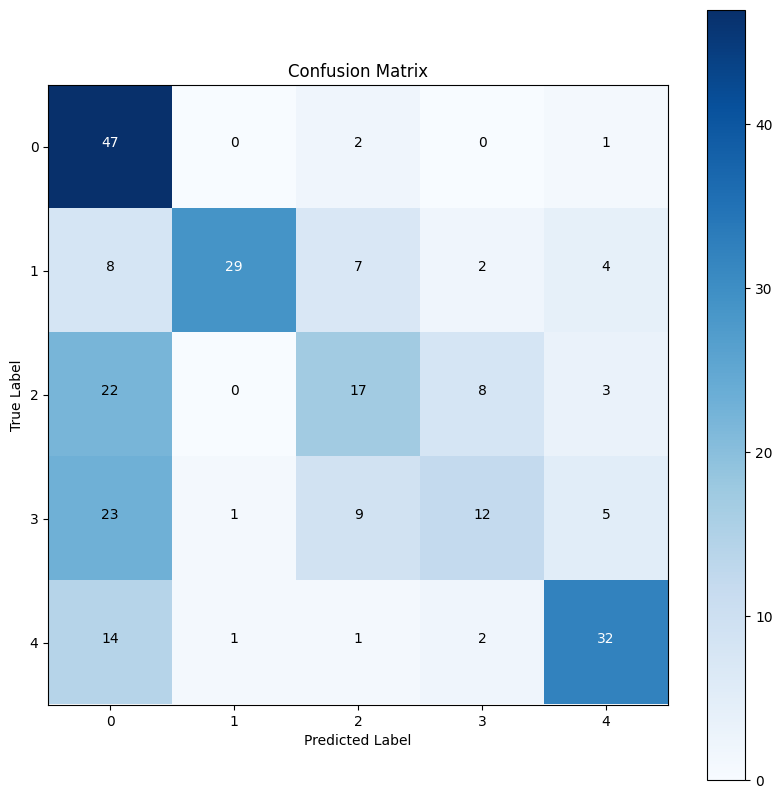

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def evaluate_model(model, X, y):
    y_pred = np.argmax(model.predict(X), axis=-1)
    y_true = np.argmax(y, axis=-1)  # Assuming y is one-hot encoded
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    sensitivity, specificity, PPV, NPV = [], [], [], []
    for i in range(len(conf_matrix)):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FN + FP)

        sensitivity.append(TP / (TP + FN) if (TP + FN) != 0 else 0)
        specificity.append(TN / (TN + FP) if (TN + FP) != 0 else 0)
        PPV.append(TP / (TP + FP) if (TP + FP) != 0 else 0)
        NPV.append(TN / (TN + FN) if (TN + FN) != 0 else 0)

    print("Accuracy:", accuracy)
    print("Sensitivity (per class):", sensitivity)
    print("Specificity (per class):", specificity)
    print("Positive Predictive Value (PPV) (per class):", PPV)
    print("Negative Predictive Value (NPV) (per class):", NPV)
    print("F1 Score:", f1)

    plot_confusion_matrix(conf_matrix)

# Assuming your test data and labels are stored in X_test and y_test_norm
evaluate_model(simple_resnet_model, X_test, y_test_norm)


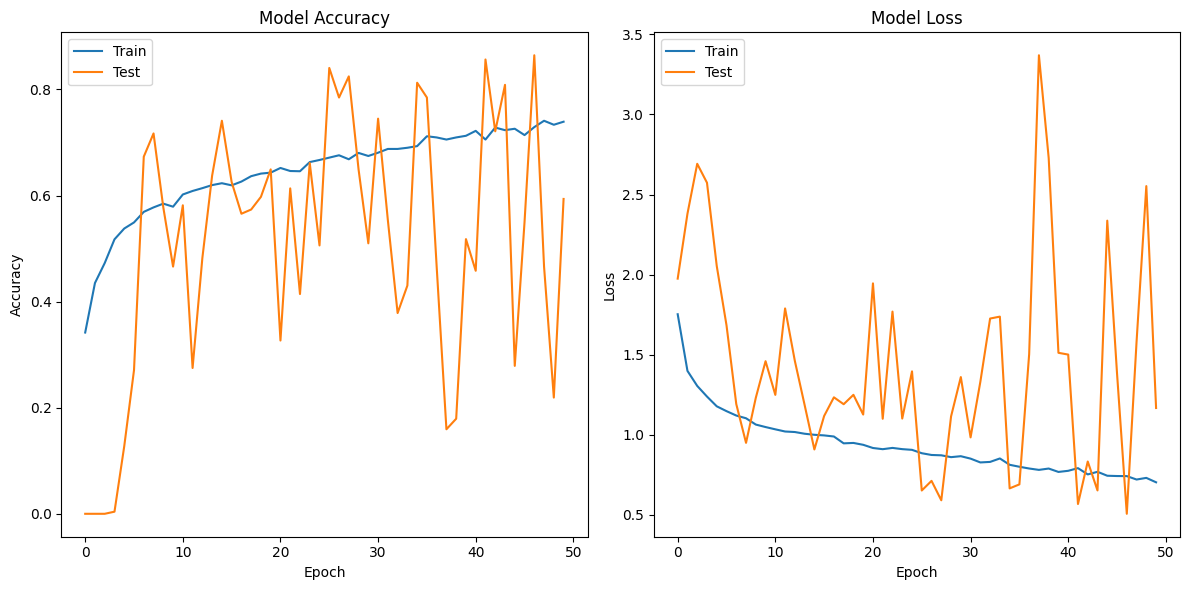

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


Shape of X_test: (250, 64, 64, 3)
Shape of y_test_norm: (250, 5)
8/8 [==============================] - 0s 20ms/step
Shape of y_pred: (250,)
Shape of y_true: (250,)
Misclassified indices: [ 14  48  49  54  57  60  62  65  66  70  71  74  75  79  83  84  85  86
  88  89  91  95  96  99 100 101 102 105 106 108 109 112 115 116 117 118
 119 120 123 124 126 127 128 129 130 131 133 134 135 137 140 141 142 144
 146 148 149 151 154 155 157 159 161 162 164 165 166 167 168 169 170 171
 172 173 174 177 178 180 181 182 183 185 187 188 189 190 191 192 193 194
 195 196 197 198 199 203 204 210 213 217 218 219 220 221 225 229 231 232
 237 241 243 247 248]


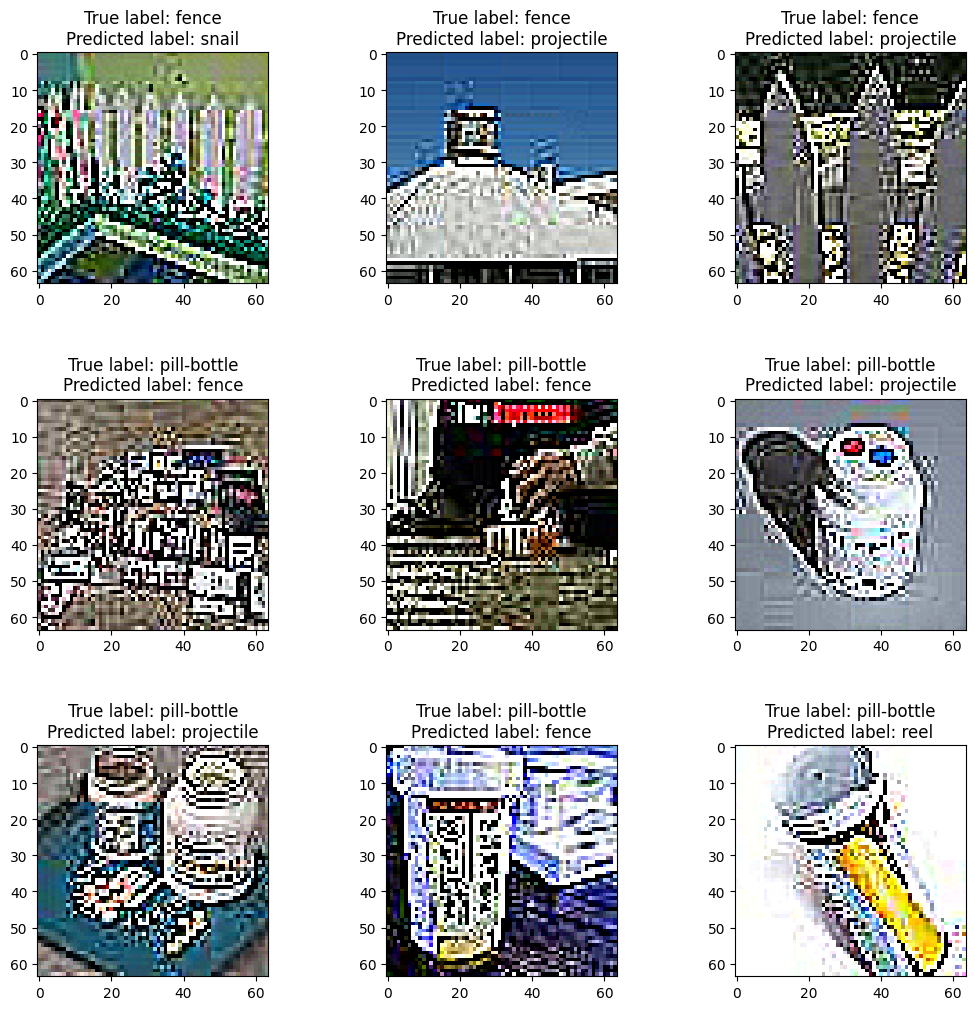

In [ ]:
# Define a list of label names based on your actual labels
label_names = ['fence', 'pill-bottle', 'projectile', 'reel', 'snail']

print("Shape of X_test:", X_test.shape)
print("Shape of y_test_norm:", y_test_norm.shape)

# Get predicted labels
y_pred = np.argmax(simple_resnet_model.predict(X_test), axis=-1)

# Get true labels
y_true = np.argmax(y_test_norm, axis=-1)

print("Shape of y_pred:", y_pred.shape)
print("Shape of y_true:", y_true.shape)

# Find misclassified examples
misclassified_idx = np.where(y_pred != y_true)[0]
print("Misclassified indices:", misclassified_idx)

# Show some misclassified examples
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Increase the spaces between plots

for i, idx in enumerate(misclassified_idx[:9]):
    ax = axes[i // 3, i % 3]
    ax.imshow((X_test[idx] * 255).astype('uint8'))  # Remove cmap='gray' if your images are in color
    ax.set_title(f"True label: {label_names[y_true[idx]]}\nPredicted label: {label_names[y_pred[idx]]}")

plt.show()